In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/Bengaluru_House_Data.csv")
data = data[['location', 'size', 'total_sqft', 'bath', 'price']]

# Feature Engineering
def extract_bhk(x):
    try:
        return int(x.split()[0])
    except:
        return None

def convert_sqft(x):
    x = str(x)
    if '-' in x:
        tokens = x.split('-')
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None

data['bhk'] = data['size'].apply(extract_bhk)
data['total_sqft'] = data['total_sqft'].apply(convert_sqft)
data.dropna(inplace=True)


In [4]:
# Clean and group rare locations
data['location'] = data['location'].str.strip()
location_stats = data['location'].value_counts()
rare_locations = location_stats[location_stats <= 10].index
data['location'] = data['location'].apply(lambda x: 'other' if x in rare_locations else x)

# Remove extreme sqft/BHK outliers
data = data[data['total_sqft']/data['bhk'] >= 300].copy()


# Add price per sqft feature
data['price_per_sqft'] = data['price'] * 1e5 / data['total_sqft']


In [5]:
# One-hot encode location
dummies = pd.get_dummies(data['location'], drop_first=True)
final_data = pd.concat([data, dummies], axis=1)
final_data.drop(['location', 'size', 'price_per_sqft'], axis=1, inplace=True)

# Define X and y
X = final_data.drop('price', axis=1)
y = final_data['price']


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV R² Score:", grid.best_score_)


Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best CV R² Score: 0.5099894015519449


In [8]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import math

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\nTest R² Score :", r2_score(y_test, y_pred))
print("Test MAE       :", mean_absolute_error(y_test, y_pred))
print("Test RMSE      :", math.sqrt(mean_squared_error(y_test, y_pred)))



Test R² Score : 0.5890144119313754
Test MAE       : 35.26962452029416
Test RMSE      : 100.22365540851996


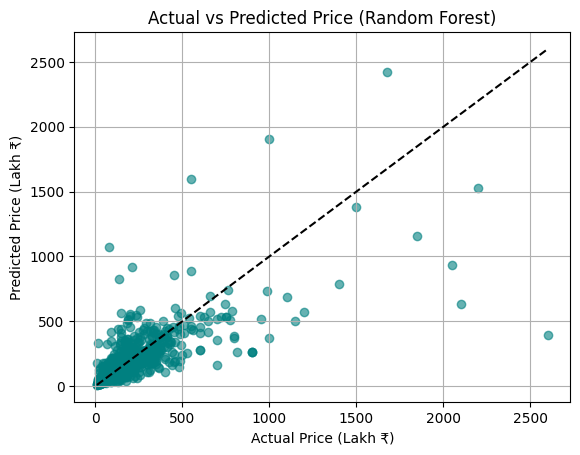

In [9]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
plt.xlabel("Actual Price (Lakh ₹)")
plt.ylabel("Predicted Price (Lakh ₹)")
plt.title("Actual vs Predicted Price (Random Forest)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.grid()
plt.show()


In [11]:
import joblib
joblib.dump(best_model, "house_price_rf_model.joblib")

def predict_price(location, sqft, bath, bhk):
    base = {'total_sqft': sqft, 'bath': bath, 'bhk': bhk}

    # Create one-hot encoded location columns with 0
    location_cols = {col: 0 for col in X.columns if col not in base}

    # Set the location to 1 if it exists
    if location in location_cols:
        location_cols[location] = 1

    # Combine into a single input row
    full_input = {**base, **location_cols}
    x_input = pd.DataFrame([full_input])  # Build single-row DataFrame
    return best_model.predict(x_input)[0]


print("Prediction ₹:", round(predict_price("Whitefield", 1200, 2, 2)*1e5, 2))


Prediction ₹: 6228805.99


In [13]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on test set
y_pred = best_model.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.3f}")
print(f"Mean Absolute Error: ₹{mae:.2f} Lakhs")
print(f"Root Mean Squared Error: ₹{rmse:.2f} Lakhs")


R² Score: 0.589
Mean Absolute Error: ₹35.27 Lakhs
Root Mean Squared Error: ₹100.22 Lakhs
